## NYC Airbnb Price Linear Regression Project

##### Notebook by David Shimshoni

This project uses the [New York City Airbnb Open Dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) from Kaggle. 

The structure of this notebook, and inspiration for code, comes from Alexey Grigorev's Machine Learning Bookcamp; specifically, [Chapter 2](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/chapter-02-car-price/02-carprice.ipynb)

### Loading in the data

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
## Reading in data

df = pd.read_csv("data/AB_NYC_2019.csv")

### Basic Exploratory Data Analysis

In [3]:
len(df) ## number of rows

48895

In [4]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


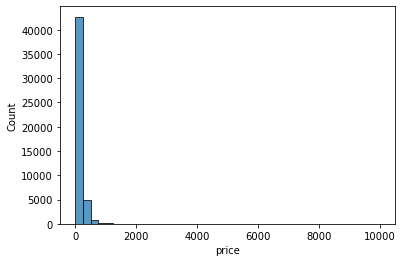

In [5]:
## Target variable analysis
sns.histplot(df.price, bins=40);

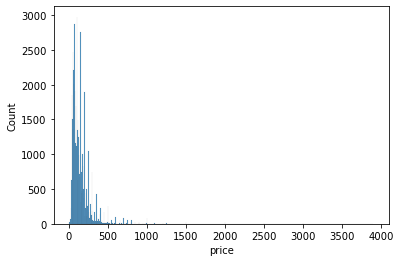

In [6]:
## Zooming into the bulk of the distribution
sns.histplot(df.price[df.price < 4000]);

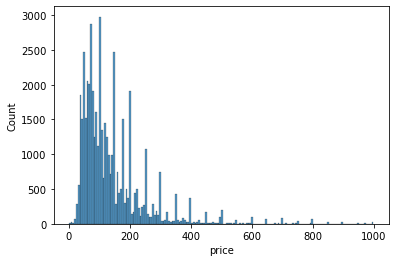

In [7]:
## The range the vast majority of the prices fall into
sns.histplot(df.price[df.price < 1000]);

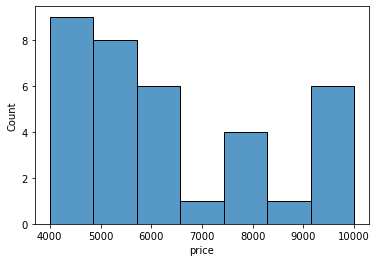

In [8]:
## Evaluating the long tail
sns.histplot(df.price[df.price >= 4000]);

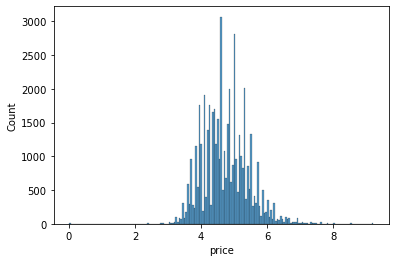

In [9]:
## Log transform to get an approximately normally distributed target
log_price_1p = np.log1p(df.price)
sns.histplot(log_price_1p);

In [10]:
## Checking for missing values
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

### Splitting the data and preparing target prices

In [11]:
## Splitting Data into validation, test, and training sets
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [12]:
## Applying log transformation to target prices
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

In [13]:
## Deleting target prices from training dataframe
del df_train['price']
del df_val['price']
del df_test['price']

In [14]:
## Looking at an example
df_train.iloc[10]

id                                              34112635
name                              CRASH PAD near LGA JFK
host_id                                         21216008
host_name                                           Jose
neighbourhood_group                               Queens
neighbourhood                            Jackson Heights
latitude                                        40.75078
longitude                                      -73.87949
room_type                                    Shared room
minimum_nights                                         1
number_of_reviews                                      4
last_review                                   2019-06-08
reviews_per_month                                   2.11
calculated_host_listings_count                         4
availability_365                                     354
Name: 44211, dtype: object

### Building the Linear Regression Model

In [15]:
## implementing OLS linear regression with numpy
def train_linear_regression(X, y):
    # adding the dummy column
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    # OLS optimization formula
    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ X.T @ y
    
    return w[0], w[1:]

In [16]:
## Predicting the price with a baseline model
base = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']  ## basic numerical feature columns
df_num = df_train[base]

In [17]:
## Filling the missing values with 0. This makes sense, as the numeric
## column with missing data (reviews_per_month) come from those 
## listings with no reviews
df_num = df_num.fillna(0)

In [18]:
## Training the OLS linear regression
X_train = df_num.values

w_0, w = train_linear_regression(X_train, y_train)

### Error Analysis

In [19]:
## Getting predictions on the training set
y_pred = w_0 + X_train @ w

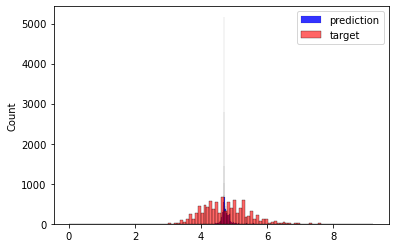

In [20]:
## Comparing the predictions and actual distribution
sns.histplot(y_pred, label='prediction', alpha=0.8, color='b')
sns.histplot(y_val, label='target', alpha=0.6, color='r')
plt.legend();

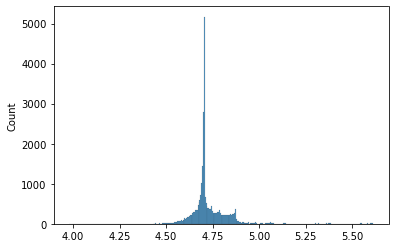

In [21]:
sns.histplot(y_pred);

In [22]:
## Numpy implementation of root mean squared error
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [23]:
## The prepare_X function for converting a Dataframe into a matrix
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [24]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val @ w
print('Baseline Validation RMSE: ', rmse(y_val, y_pred))

Baseline Validation RMSE:  0.684838957356789


### Adding Categorical Features and Regularization

In [25]:
df_train.neighbourhood_group.value_counts()

Manhattan        12991
Brooklyn         12015
Queens            3466
Bronx              651
Staten Island      214
Name: neighbourhood_group, dtype: int64

In [26]:
## Creating a new prepare_X to add dummy variables for borough
def prepare_X(df):
    base = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']
    features = base.copy()
    
    df_num = df[base]
    df_num = df_num.fillna(0)
    
    for borough in ['Manhattan', 'Brooklyn', 'Queens', 'Bronx',
                   'Staten Island']:
        feature = 'is_borough_%s' % borough
        df_num[feature] = (df['neighbourhood_group'] == borough).astype(int)
        features.append(feature)
    
    X = df_num.values
    return X

In [27]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val @ w
print('Validation RMSE after adding categorical dummies:', rmse(y_val, y_pred))

Validation RMSE after adding categorical dummies: 101.38684435038431


In [28]:
## OLS Linear Regression with regularization
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T @ X
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv @ X.T @ y
    return w[0], w[1:]

In [29]:
## Testing different regularization values on the weight values
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print(f'r = {r}')
    print(f"Bias: {w_0}")
    print(f"Weights: {w}")
    print('\n')

r = 0
Bias: 121.76088868149218
Weights: [-1.86888600e-01  4.03890878e-03  1.28350568e+00 -7.67616629e-02
  9.21143204e-03  6.37788028e+00 -3.69701417e+01 -4.23158552e+01
 -4.55919537e+01 -4.61110577e+01]


r = 0.001
Bias: 3.7126976628381927
Weights: [-5.81696944e-04 -2.82394241e-04 -1.72407077e-02  1.16588150e-03
  5.99567142e-04  1.23673601e+00  8.28077749e-01  6.19433045e-01
  4.61187028e-01  5.67263829e-01]


r = 0.01
Bias: 3.7126905827569416
Weights: [-5.81683306e-04 -2.82393996e-04 -1.72402185e-02  1.16588074e-03
  5.99574934e-04  1.23674078e+00  8.28082834e-01  6.19436545e-01
  4.61185665e-01  5.67244752e-01]


r = 0.1
Bias: 3.7126197335489852
Weights: [-5.81546884e-04 -2.82391527e-04 -1.72353282e-02  1.16587316e-03
  5.99652837e-04  1.23678850e+00  8.28133670e-01  6.19471542e-01
  4.61171997e-01  5.67054027e-01]


r = 1
Bias: 3.7119127876271554
Weights: [-5.80182372e-04 -2.82366499e-04 -1.71864426e-02  1.16579798e-03
  6.00431365e-04  1.23726410e+00  8.28640506e-01  6.19819966e-

In [30]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val @ w
print('Validation RMSE after adding borough categorical dummies and adding regularization:', rmse(y_val, y_pred))

Validation RMSE after adding borough categorical dummies and adding regularization: 0.6395063414603269


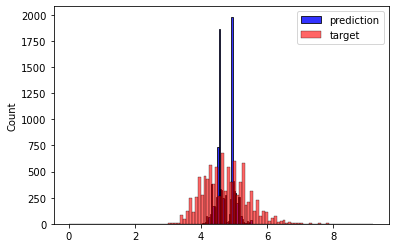

In [31]:
## Comparing the predictions and actual distribution
sns.histplot(y_pred, label='prediction', alpha=0.8, color='b')
sns.histplot(y_val, label='target', alpha=0.6, color='r')
plt.legend();

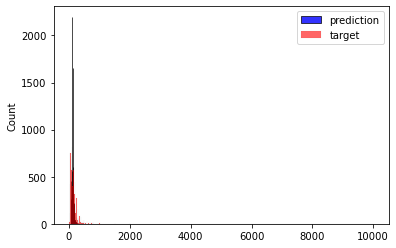

In [32]:
## Comparing the predictions and actual distribution for true price
sns.histplot(np.exp(y_pred)-1, label='prediction', alpha=0.8, color='b')
sns.histplot(np.exp(y_val)-1, label='target', alpha=0.6, color='r')
plt.legend();

In [33]:
print('Validation USD RMSE after adding borough categorical dummies and adding regularization:', rmse(np.exp(y_val)-1, np.exp(y_pred)-1))

Validation USD RMSE after adding borough categorical dummies and adding regularization: 241.22320832979665


In [34]:
## Creating a new prepare_X to add dummy variables for neighborhood
def prepare_X(df):
    base = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']
    features = base.copy()
    
    df_num = df[base]
    df_num = df_num.fillna(0)
    
    for borough in ['Manhattan', 'Brooklyn', 'Queens', 'Bronx',
                   'Staten Island']:
        feature = 'is_borough_%s' % borough
        df_num[feature] = (df['neighbourhood_group'] == borough).astype(int)
        features.append(feature)
        
    for neighborhood in df_train['neighbourhood'].unique():
        feature = 'is_neighborhood_%s' % borough
        df_num[feature] = (df['neighbourhood'] == neighborhood).astype(int)
        features.append(feature)
    
    X = df_num.values
    return X

In [35]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val @ w
print('Validation RMSE after also adding neighborhood categorical dummies and some regularization:', rmse(y_val, y_pred))

Validation RMSE after also adding neighborhood categorical dummies and some regularization: 0.6395293528406962


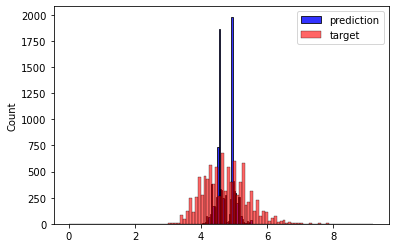

In [36]:
sns.histplot(y_pred, label='prediction', alpha=0.8, color='b')
sns.histplot(y_val, label='target', alpha=0.6, color='r')
plt.legend();

In [37]:
## Creating a new prepare_X to add dummy variables for room type
def prepare_X(df):
    base = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']
    features = base.copy()
    
    df_num = df[base]
    df_num = df_num.fillna(0)
    
    for borough in ['Manhattan', 'Brooklyn', 'Queens', 'Bronx',
                   'Staten Island']:
        feature = 'is_borough_%s' % borough
        df_num[feature] = (df['neighbourhood_group'] == borough).astype(int)
        features.append(feature)
        
    for neighborhood in df_train['neighbourhood'].unique():
        feature = 'is_neighborhood_%s' % neighborhood
        df_num[feature] = (df['neighbourhood'] == neighborhood).astype(int)
        features.append(feature)
        
    for room_type in df_train['room_type'].unique():
        feature = 'is_room_type_%s' % room_type
        df_num[feature] = (df['room_type'] == room_type).astype(int)
        features.append(feature)    
    
    X = df_num.values
    return X

In [38]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val @ w
print('Validation RMSE after also adding room type categorical dummies and some regularization:', rmse(y_val, y_pred))

/var/folders/jm/8xl351xd0cd8jdk89j_x_g180000gn/T/ipykernel_50489/2364852936.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[feature] = (df['neighbourhood'] == neighborhood).astype(int)
/var/folders/jm/8xl351xd0cd8jdk89j_x_g180000gn/T/ipykernel_50489/2364852936.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[feature] = (df['room_type'] == room_type).astype(int)


Validation RMSE after also adding room type categorical dummies and some regularization: 0.4721684720057483


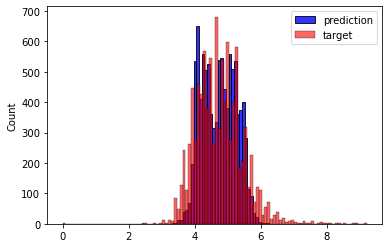

In [39]:
sns.histplot(y_pred, label='prediction', alpha=0.8, color='b')
sns.histplot(y_val, label='target', alpha=0.6, color='r')
plt.legend();

### Regularization Hyperparameter Selection

In [40]:
## Trying out different values of reg_param to optimize validation RMSE
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val @ w
    print('%6s' % r, rmse(y_val, y_pred))

/var/folders/jm/8xl351xd0cd8jdk89j_x_g180000gn/T/ipykernel_50489/2364852936.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[feature] = (df['neighbourhood'] == neighborhood).astype(int)
/var/folders/jm/8xl351xd0cd8jdk89j_x_g180000gn/T/ipykernel_50489/2364852936.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[feature] = (df['room_type'] == room_type).astype(int)


 1e-06 21.8228741184905
0.0001 0.47218699186598506
 0.001 0.4721684720057483
  0.01 0.47214228452442986
   0.1 0.4719096795942213
     1 0.47086974669572185
     5 0.47011507060309315
    10 0.4699914974612546
   100 0.4726497287947778


### Final Model Construction and Inference

In [41]:
## It seems the best-performing model comes from r=10, so let's use this
## as our final model

X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=10)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val @ w
print('validation: ', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test @ w
print('test: ', rmse(y_test, y_pred))

/var/folders/jm/8xl351xd0cd8jdk89j_x_g180000gn/T/ipykernel_50489/2364852936.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[feature] = (df['neighbourhood'] == neighborhood).astype(int)
/var/folders/jm/8xl351xd0cd8jdk89j_x_g180000gn/T/ipykernel_50489/2364852936.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[feature] = (df['room_type'] == room_type).astype(int)


validation:  0.4699914974612546
test:  0.4903363239461685


In [42]:
example_index = 40
example = df_test.iloc[example_index].to_dict()
example

{'id': 28560966,
 'name': 'New York Apartment',
 'host_id': 83343316,
 'host_name': 'Jamie',
 'neighbourhood_group': 'Manhattan',
 'neighbourhood': 'Kips Bay',
 'latitude': 40.73954,
 'longitude': -73.98185,
 'room_type': 'Private room',
 'minimum_nights': 2,
 'number_of_reviews': 2,
 'last_review': '2018-11-25',
 'reviews_per_month': 0.26,
 'calculated_host_listings_count': 1,
 'availability_365': 45}

In [43]:
X_example = prepare_X(pd.DataFrame([example]))
y_example_pred = w_0 + X_example @ w
price_prediction = np.expm1(y_example_pred)
print(f"Predicted price: {price_prediction[0]:.2f}")

actual_price = np.expm1(y_test[example_index])
print(f"Actual price: {actual_price:.2f}")

Predicted price: 94.09
Actual price: 150.00


/var/folders/jm/8xl351xd0cd8jdk89j_x_g180000gn/T/ipykernel_50489/2364852936.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[feature] = (df['neighbourhood'] == neighborhood).astype(int)
/var/folders/jm/8xl351xd0cd8jdk89j_x_g180000gn/T/ipykernel_50489/2364852936.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[feature] = (df['room_type'] == room_type).astype(int)


### Extra: Exploring potential of adding embeddings of the listing name as features

In [44]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
example_embeddings = embedding_model.encode(df_train.iloc[:15]['name'].values)
print(example_embeddings[0][:10])

[-0.01046909  0.00674606 -0.05004983 -0.02677302 -0.03129811  0.00018769
  0.01781637 -0.0354561  -0.00137843 -0.03198716]


In [45]:
len(example_embeddings[0])

384

In [46]:
## Adding embeddings of the listing names to the Prepare_X function
def prepare_X(df):
    base = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']
    features = base.copy()
    
    df_num = df[base]
    df_num = df_num.fillna(0)
    
    for borough in ['Manhattan', 'Brooklyn', 'Queens', 'Bronx',
                   'Staten Island']:
        feature = 'is_borough_%s' % borough
        df_num[feature] = (df['neighbourhood_group'] == borough).astype(int)
        features.append(feature)
        
    for neighborhood in df_train['neighbourhood'].unique():
        feature = 'is_neighborhood_%s' % neighborhood
        df_num[feature] = (df['neighbourhood'] == neighborhood).astype(int)
        features.append(feature)
        
    for room_type in df_train['room_type'].unique():
        feature = 'is_room_type_%s' % room_type
        df_num[feature] = (df['room_type'] == room_type).astype(int)
        features.append(feature)    
    
    X = df_num.values
    
    name_embeddings = embedding_model.encode(df['name'].values)
    X = np.column_stack(X, name_embeddings)
    return X

In [47]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val @ w
print('Validation RMSE after adding name embeddings with some regularization:', rmse(y_val, y_pred))

/var/folders/jm/8xl351xd0cd8jdk89j_x_g180000gn/T/ipykernel_50489/2643993935.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[feature] = (df['neighbourhood'] == neighborhood).astype(int)
/var/folders/jm/8xl351xd0cd8jdk89j_x_g180000gn/T/ipykernel_50489/2643993935.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_num[feature] = (df['room_type'] == room_type).astype(int)


TypeError: _column_stack_dispatcher() takes 1 positional argument but 2 were given

This increased validation performance, even without hyperparameter optimization, indicates that adding embeddings for the listing name as a feature is a promising approach to increasing performance further.